In [12]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd

from cleaning import clean_data
from evaluate import qwk


from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold

from sklearn import ensemble

from mpl_toolkits import mplot3d

In [2]:
# Generating 3 datasets that reduce collinearity in the features
# Load Data
X_train, y_train, X_test, y_test = clean_data('')

# PCA Decomposition
pca = PCA(svd_solver='full')
pcaX_train = pca.fit_transform(X_train)
pcaX_test = pca.transform(X_test)

# Select K Best
kb = SelectKBest()
kbX_train = kb.fit_transform(X_train, y_train)
kbX_test = kb.transform(X_test)

# Variance Threshold
vt = VarianceThreshold(threshold=(.8 * (1 - .8)))
vtX_train = vt.fit_transform(X_train, y_train)
vtX_test = vt.transform(X_test)

print(f'Training = {X_train.shape}')
print(f'Testing = {X_test.shape}')
# Create dict to store outcomes


Training = (10495, 335)
Testing = (4498, 335)


In [6]:
# Testing which dataset produces the best result on the linear regressor
controlLogReg = ensemble.GradientBoostingRegressor()
kbLogReg = ensemble.GradientBoostingRegressor()
pcaLogReg = ensemble.GradientBoostingRegressor()
vtLogReg = ensemble.GradientBoostingRegressor()

controlLogReg.fit(X_train, y_train)
kbLogReg.fit(kbX_train, y_train)
pcaLogReg.fit(pcaX_train, y_train)
vtLogReg.fit(vtX_train, y_train)

print("============= control ======================")
print("train acc: " + str(controlLogReg.score(X_train, y_train)))
print("test acc: " + str(controlLogReg.score(X_test, y_test)))

print("============= K best ======================")
print("train acc: " + str(kbLogReg.score(kbX_train, y_train)))
print("test acc: " + str(kbLogReg.score(kbX_test, y_test)))

print("============= PCA Decomposition ======================")
print("train acc: " + str(pcaLogReg.score(pcaX_train, y_train)))
print("test acc: " + str(pcaLogReg.score(pcaX_test, y_test)))

print("============= Variance Threshold ======================")
print("train acc: " + str(vtLogReg.score(vtX_train, y_train)))
print("test acc: " + str(vtLogReg.score(vtX_test, y_test)))


============= control ======================
train acc: 0.2004869603016015
test acc: 0.15395712010749807
============= K best ======================
train acc: 0.170004889558243
test acc: 0.14088230357018072
============= PCA Decomposition ======================
train acc: 0.2501164710083923
test acc: 0.11180560345203883
============= Variance Threshold ======================
train acc: 0.1894034186214375
test acc: 0.1488303067115362


In [10]:
# Trying a rounding function to sort the results into buckets
# Using the best test result from the test above

def roundGuess(guesses):
    for i, guess in enumerate(guesses):
        if guess < 0.5:
            guesses[i] = 0
        elif guess < 1.5:
            guesses[i] = 1
        elif guess < 2.5:
            guesses[i] = 2    
        elif guess < 3.5:
            guesses[i] = 3
        elif guess < 4.5:
            guesses[i] = 4
        else: guesses[i] = 5
    return guesses     

preds = controlLogReg.predict(X_test)
roundedPreds = roundGuess(preds)

print("Acc without rounding: " + str(mean_squared_error(preds, y_test)))
print("Acc with rounding: " + str(mean_squared_error(roundedPreds, y_test)))


[2. 3. 3. ... 2. 2. 3.]
[2. 3. 3. ... 2. 2. 3.]
Acc without rounding: 1.227879057358826
Acc with rounding: 1.227879057358826


In [35]:
# Trying different learning rates and max depths on the regressor
results = pd.DataFrame(columns=range(1,20))
lrs = [0.1,0.2,0.3,0.4,0.5]
depths = range(2,7)
i = 0
Z = []

for depth in depths:
    print(str(depth))
    Z.append([])
    for lr in lrs:
        reg = ensemble.GradientBoostingRegressor(learning_rate=lr, max_depth=depth)
        reg.fit(X_train, y_train)
        score = reg.score(X_test, y_test)
        Z[i].append(score)
        print(str(lr)+ ": " + str(score))
    i+=1

Z = np.array(Z)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(lrs,depths, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_xlabel('Learning Rates')
ax.set_ylabel('Depths')
ax.set_zlabel('Score')

ax.set_title('LR and Depth comparison');

plt.show()
# Will 3D plot these results soon

2
0.1: 0.14443142805999398
0.2: 0.15200817476788453


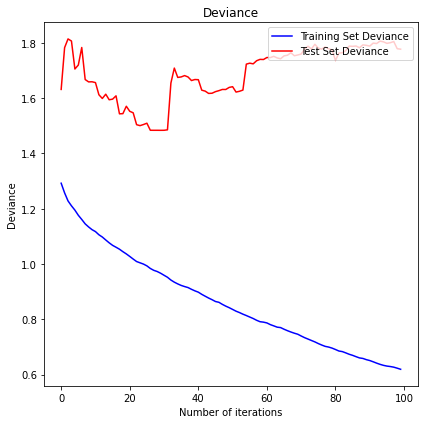

In [ ]:
# Can look at changing variance and bias with subsample variable
# Can look at changing criterion
test_score = np.zeros(100, dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6,6))
plt.subplot(1,1,1)
plt.title('Deviance')

plt.plot(range(0,100), reg.train_score_, "b-", label='Training Set Deviance')
plt.plot(range(0,100), test_score, "r-", label='Test Set Deviance')

plt.legend(loc='upper right')
plt.xlabel("Number of iterations")
plt.ylabel("Deviance")

fig.tight_layout()
plt.show()
